### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta, date
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import scipy.stats as ss

%matplotlib inline

In [2]:
# Setting option to display all columns for dataframes
pd.set_option('display.max_columns', None)

# Charts style in seaborn
sns.set_style(style='white', rc=None)

### Import data from tweets

Let's start by importing our processed data and see how many tweets we have for each stock.

In [3]:
stocks_merged = pd.read_csv('..\data\stocks_merged.csv', index_col=0, parse_dates=['datetime'])
stocks_merged.shape

(16327, 24)

In [4]:
# Breakdown of tweets by stock
stocks_merged.groupby('stock').count()['price_movement']

stock
GOOGL    7876
JPM      4503
XOM      3948
Name: price_movement, dtype: int64

In [5]:
stocks_merged.head(1)

,datetime,text,username,likeCount,replyCount,retweetCount,stock,date_x,hour,minutes,dayofweek,predictiondate,price_movement,processed_text,tickers,number_tickers,hashtags,number_hashtags,mentions,number_mentions,text_length,lem_text,sentiment_label,sentiment_score
0,2018-12-30 20:50:51-05:00,$GOOGL Chicago District judge Edmond Chang dis...,Trade_The_News,1,0,0,GOOGL,2018-12-30,20,50,6,2018-12-31,1,$googl chicago district judge edmond chang dis...,['$googl'],1,[],0,[],0,185,$googl chicago district judge edmond chang dis...,neutral,0.781874


Let's drop some columns we will not use for the EDA and store our lemmatized text in a separate dataframe.

In [6]:
stocks_text = stocks_merged[['stock','lem_text','price_movement']]

In [7]:
stocks_merged = stocks_merged.drop(columns=['datetime','text','replyCount','retweetCount','predictiondate',\
                                          'processed_text','tickers','number_tickers','lem_text','hashtags','mentions'])
stocks_merged.head(1)

,username,likeCount,stock,date_x,hour,minutes,dayofweek,price_movement,number_hashtags,number_mentions,text_length,sentiment_label,sentiment_score
0,Trade_The_News,1,GOOGL,2018-12-30,20,50,6,1,0,0,185,neutral,0.781874


Segmenting numerical and categorical columns in case we need it later.

In [8]:
# Segmenting numerical and categorical columns

num_cols = stocks_merged.select_dtypes(include=['number']).columns.tolist()
cat_cols = stocks_merged.select_dtypes(include=['object', 'category']).columns.tolist()

print(num_cols)
print(cat_cols)

['likeCount', 'hour', 'minutes', 'dayofweek', 'price_movement', 'number_hashtags', 'number_mentions', 'text_length', 'sentiment_score']
['username', 'stock', 'date_x', 'sentiment_label']


### Stock historical price change

We'll download and chart the historical price changes for the stocks as a reference.

In [9]:
googl_stock = yf.download(tickers = 'GOOGL', start='2018-01-01', end='2022-12-31', interval = '1d', rounding=True)
xom_stock = yf.download(tickers = 'XOM', start='2018-01-01', end='2022-12-31', interval = '1d', rounding=True)
jpm_stock = yf.download(tickers = 'JPM', start='2018-01-01', end='2022-12-31', interval = '1d', rounding=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


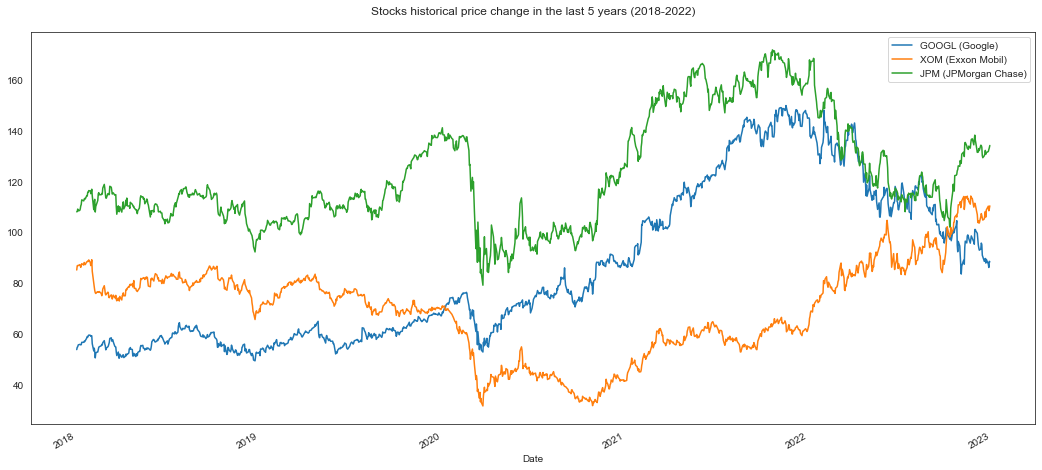

In [10]:
plt.figure(figsize=(18,8))
googl_stock['Close'].plot(label='GOOGL (Google)')
xom_stock['Close'].plot(label='XOM (Exxon Mobil)')
jpm_stock['Close'].plot(label='JPM (JPMorgan Chase)')
plt.legend()
plt.title('Stocks historical price change in the last 5 years (2018-2022)\n');

### EDA - features other than tweet text

#### Price movement (target variable)

In [11]:
stocks = ['GOOGL', 'XOM', 'JPM']

In [12]:
for stock in stocks:
    print(f'\n{stock}\n',stocks_merged[stocks_merged.stock == stock]['price_movement'].value_counts(normalize=True))


GOOGL
 1    0.610843
0    0.389157
Name: price_movement, dtype: float64

XOM
 1    0.575228
0    0.424772
Name: price_movement, dtype: float64

JPM
 1    0.578725
0    0.421275
Name: price_movement, dtype: float64


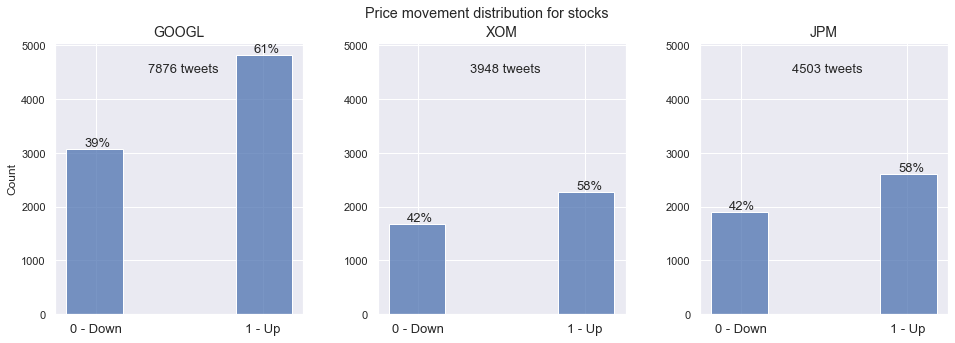

In [13]:
sns.set(rc={'figure.figsize':(16, 5)})
fig, ax = plt.subplots(1, 3, sharey=True)
fig.suptitle('Price movement distribution for stocks\n')

for i, stock in enumerate(stocks):
    sns.histplot(data=stocks_merged[stocks_merged['stock'] == stock], x='price_movement', ax=ax[i], binwidth=0.25)
    ax[i].set_title(stock, fontdict={'fontsize':14})
    ax[i].yaxis.set_tick_params(labelbottom=True)
    ax[i].set_xticks(ticks=[0.13,0.87], labels=['0 - Down','1 - Up'], fontsize=13)
    #ax[i].set_yticks(ticks=np.arange(0,5000,1000), fontsize=14)
    ax[i].set_xlabel(None)

ax[0].annotate('39%', (0.08,3130), fontsize=13)
ax[0].annotate('61%', (0.83,4870), fontsize=13)
ax[0].annotate('7876 tweets', (0.36,4500), fontsize=13)

ax[1].annotate('42%', (0.08,1730), fontsize=13)
ax[1].annotate('58%', (0.83,2320), fontsize=13)
ax[1].annotate('3948 tweets', (0.36,4500), fontsize=13)

ax[2].annotate('42%', (0.08,1950), fontsize=13)
ax[2].annotate('58%', (0.83,2650), fontsize=13)
ax[2].annotate('4503 tweets', (0.36,4500), fontsize=13)

plt.subplots_adjust(wspace=0.3)  
plt.show();

#### Username

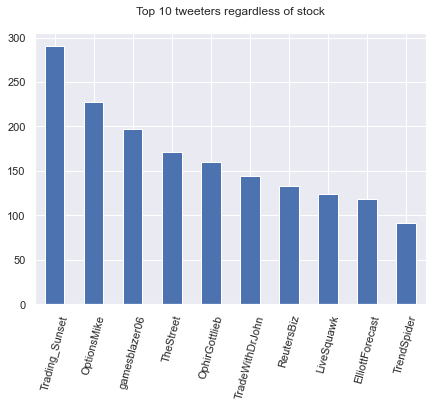

In [14]:
plt.figure(figsize=(7,5))
stocks_merged.groupby('username').count()['price_movement'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 tweeters regardless of stock\n')
plt.xlabel(None)
plt.xticks(rotation=75);

Let's explore the top tweet usernames by stock

In [15]:
def plot_usernames(stock):
    sns.set(rc={'figure.figsize':(16, 5)})
    fig, ax = plt.subplots(1, 2, sharey=True)
    fig.suptitle(stock)

    stocks_merged[(stocks_merged.stock == stock) & (stocks_merged.price_movement == 1)].\
            groupby('username').count()['price_movement'].sort_values(ascending=False).head(10).plot(kind='bar', ax=ax[0])
    ax[0].title.set_text('Top 10 usernames for price going UP')
    ax[0].set_xlabel(None)
    ax[0].xaxis.set_tick_params(labelrotation=75)

    stocks_merged[(stocks_merged.stock == stock) & (stocks_merged.price_movement == 0)].\
            groupby('username').count()['price_movement'].sort_values(ascending=False).head(10).plot(kind='bar', ax=ax[1])
    ax[1].title.set_text('Top 10 usernames for price going DOWN')
    ax[1].set_xlabel(None)
    ax[1].yaxis.set_tick_params(labelbottom=True)
    ax[1].xaxis.set_tick_params(labelrotation=75)

    plt.subplots_adjust(wspace=0.2)  
    plt.show();

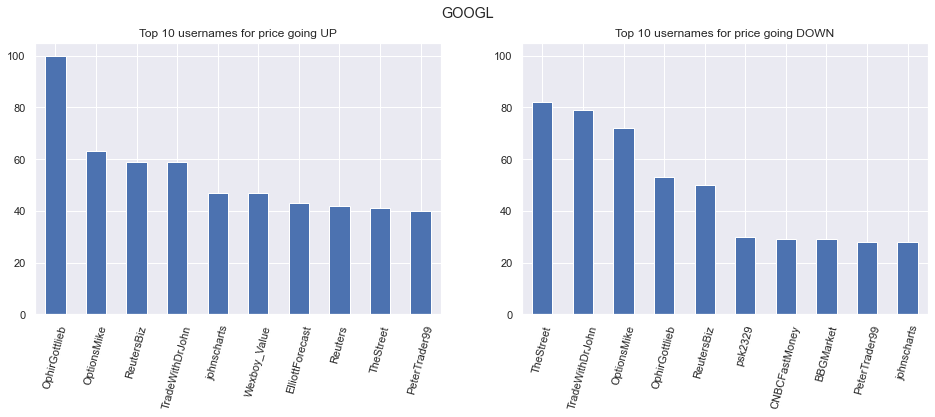

In [16]:
plot_usernames('GOOGL')

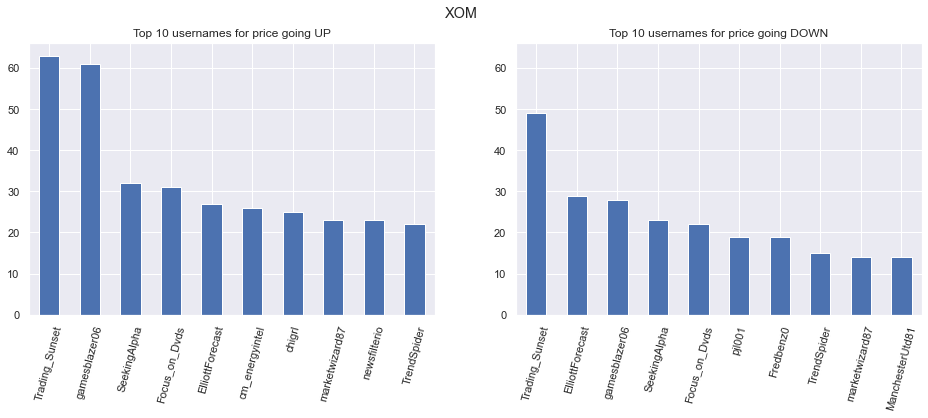

In [17]:
plot_usernames('XOM')

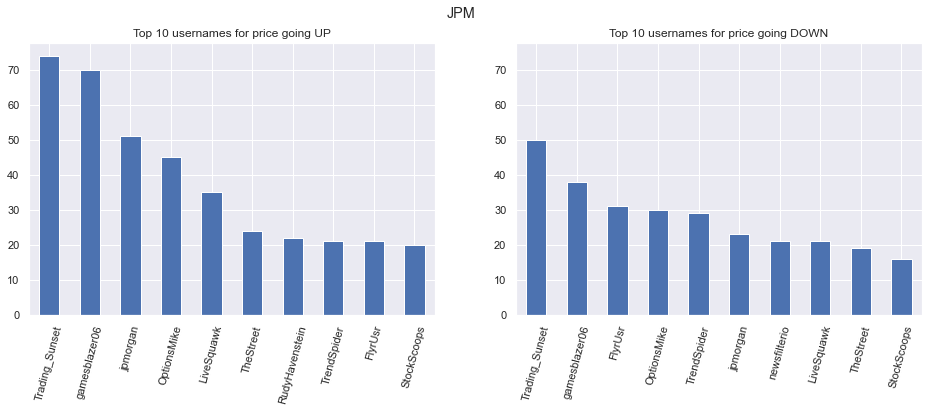

In [18]:
plot_usernames('JPM')

#### likeCount

In [19]:
stocks_merged.likeCount.value_counts(normalize=True).head(5)

1    0.331965
2    0.155693
3    0.101243
4    0.062963
5    0.047222
Name: likeCount, dtype: float64

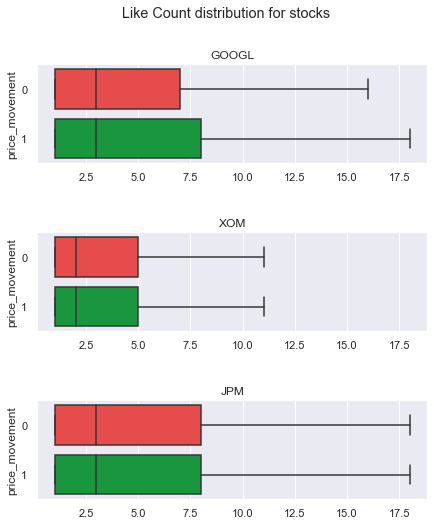

In [20]:
sns.set(rc={'figure.figsize':(7, 8)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Like Count distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='likeCount', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.7)  
plt.show();

#### hour

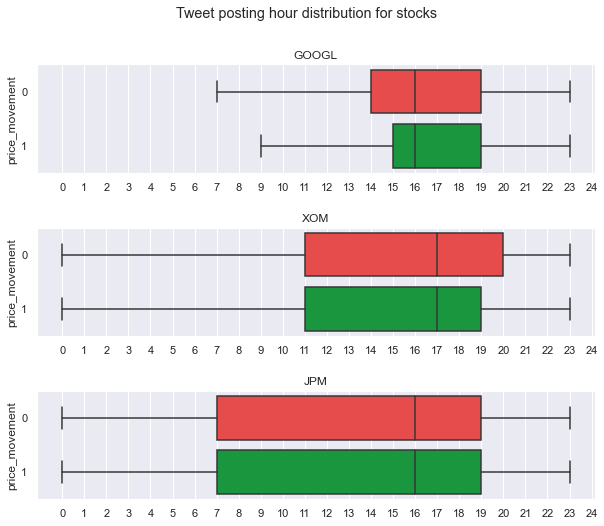

In [151]:
sns.set(rc={'figure.figsize':(10, 8)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet posting hour distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='hour', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].set_xticks(np.arange(0,25))
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.5)  
plt.show();

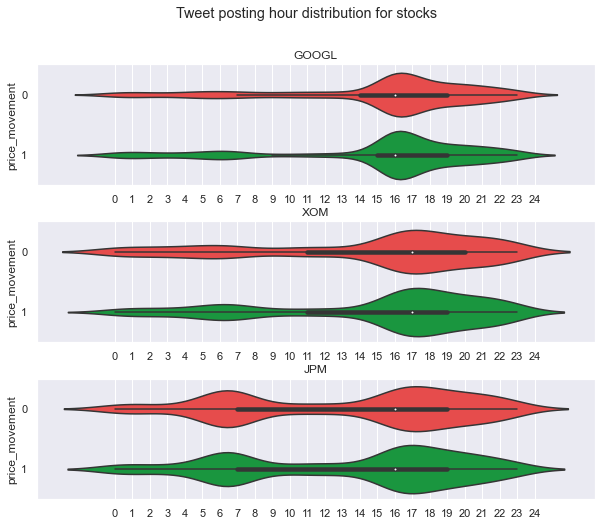

In [152]:
sns.set(rc={'figure.figsize':(10, 8)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet posting hour distribution for stocks')

for i, stock in enumerate(stocks):
    sns.violinplot(data=stocks_merged[stocks_merged.stock == stock], x='hour', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].set_xticks(np.arange(0,25))
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.3)  
plt.show();

#### minutes

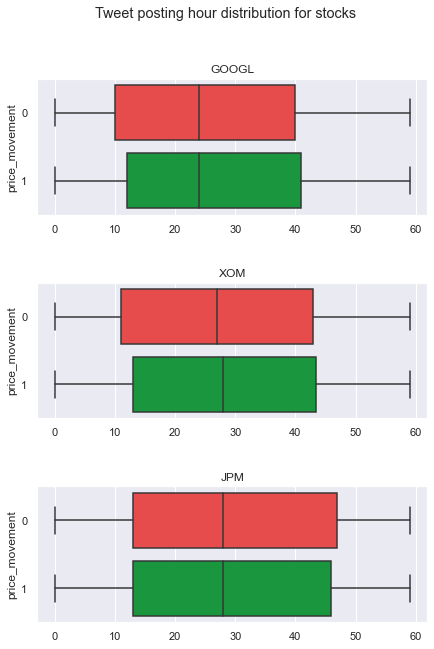

In [23]:
sns.set(rc={'figure.figsize':(7, 10)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet posting hour distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='minutes', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].set_xticks(np.arange(0,61,10))
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.5)  
plt.show();

#### dayofweek

In [24]:
def get_days_of_week(df):
    
    dow_df = pd.DataFrame(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], columns=['dayofweek'])
    dow_df['price_up_count'] = df[df['price_movement'] == 1].\
                            groupby('dayofweek').count()['likeCount'].sort_index().values
    dow_df['price_down_count'] = df[df['price_movement'] == 0].\
                            groupby('dayofweek').count()['likeCount'].sort_index().values
    
    return dow_df

In [25]:
googl_dow_df = get_days_of_week(stocks_merged[stocks_merged['stock'] == 'GOOGL'])
xom_dow_df = get_days_of_week(stocks_merged[stocks_merged['stock'] == 'XOM'])
jpm_dow_df = get_days_of_week(stocks_merged[stocks_merged['stock'] == 'JPM'])

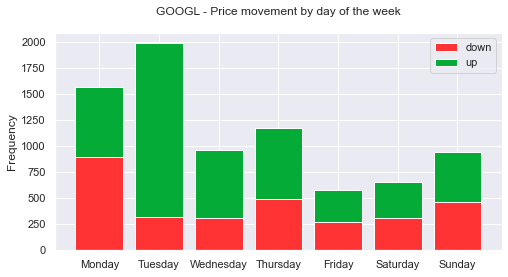

In [26]:
plt.figure(figsize=(8,4))
plt.bar(googl_dow_df['dayofweek'], googl_dow_df['price_down_count'], color='#FF3333', label='down')
plt.bar(googl_dow_df['dayofweek'], googl_dow_df['price_up_count'], bottom=googl_dow_df['price_down_count'], color='#05AB37', label='up')
plt.ylabel('Frequency')
plt.title('GOOGL - Price movement by day of the week\n')
plt.legend();

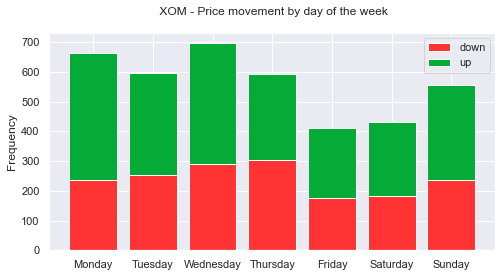

In [27]:
plt.figure(figsize=(8,4))
plt.bar(xom_dow_df['dayofweek'], xom_dow_df['price_down_count'], color='#FF3333', label='down')
plt.bar(xom_dow_df['dayofweek'], xom_dow_df['price_up_count'], bottom=xom_dow_df['price_down_count'], color='#05AB37', label='up')
plt.ylabel('Frequency')
plt.title(' XOM - Price movement by day of the week\n')
plt.legend();

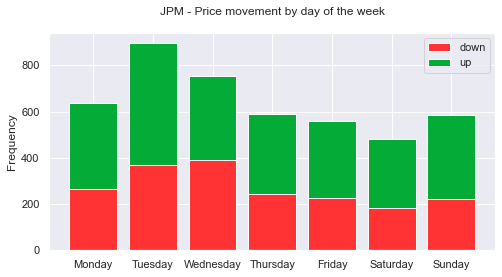

In [28]:
plt.figure(figsize=(8,4))
plt.bar(jpm_dow_df['dayofweek'], jpm_dow_df['price_down_count'], color='#FF3333', label='down')
plt.bar(jpm_dow_df['dayofweek'], jpm_dow_df['price_up_count'], bottom=jpm_dow_df['price_down_count'], color='#05AB37', label='up')
plt.ylabel('Frequency')
plt.title('JPM - Price movement by day of the week\n')
plt.legend();

#### Number of hashtags and mentions

We won't do analysis on hashtags and mentions, since the majority of the tweets in our dataset don't have them. Below you can see the percentage breakdown.

In [29]:
stocks_merged.number_hashtags.value_counts(normalize=True).head()

0    0.808354
1    0.095731
2    0.042690
3    0.024683
4    0.007779
Name: number_hashtags, dtype: float64

In [30]:
stocks_merged.number_mentions.value_counts(normalize=True).head()

0    0.702272
1    0.212838
2    0.052735
3    0.015496
4    0.007227
Name: number_mentions, dtype: float64

#### text length

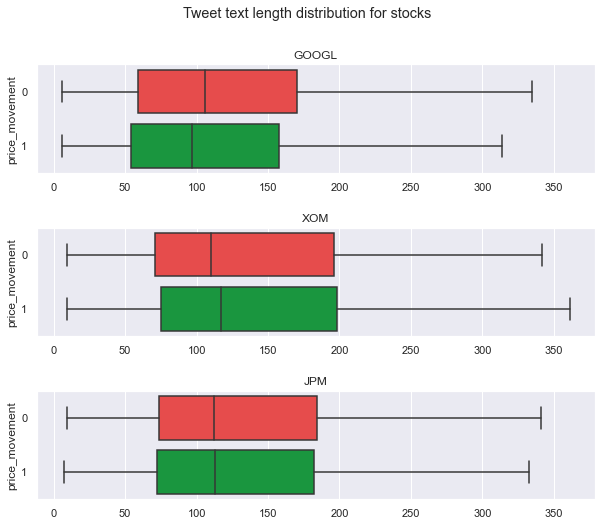

In [154]:
sns.set(rc={'figure.figsize':(10, 8)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet text length distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='text_length', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.5)  
plt.show();

#### sentiment label

In [32]:
def get_sentiment_df(df):
    
    sentiment_df = pd.DataFrame([0, 1], columns=['price_movement'])
    
    sentiment_df['negative'] = df[df['sentiment_label'] == 'negative'].groupby('price_movement').count()['likeCount']
    sentiment_df['neutral'] = df[df['sentiment_label'] == 'neutral'].groupby('price_movement').count()['likeCount']         
    sentiment_df['positive'] = df[df['sentiment_label'] == 'positive'].groupby('price_movement').count()['likeCount']
                                
    return sentiment_df

In [33]:
googl_sentiment_df = get_sentiment_df(stocks_merged[stocks_merged['stock'] == 'GOOGL'])
xom_sentiment_df = get_sentiment_df(stocks_merged[stocks_merged['stock'] == 'XOM'])
jpm_sentiment_df = get_sentiment_df(stocks_merged[stocks_merged['stock'] == 'JPM'])

In [34]:
def plot_sentiment(df, stock):
    
    plt.figure(figsize=(4,5))
    plt.bar(df['price_movement'], df['negative'], color='red', label='negative', width=0.7)
    plt.bar(df['price_movement'], df['neutral'], color='grey', label='neutral', bottom=df['negative'], width=0.7)
    plt.bar(df['price_movement'], df['positive'], color='green', label='positive',\
                bottom=df['negative']+df['neutral'], width=0.7)
    plt.ylabel('Frequency')
    plt.title(f'{stock} - Sentiment label by price movement\n')
    plt.xticks(ticks=[0,1], labels=['price down','price up'])
    plt.legend();

In [143]:
stocks_merged[stocks_merged['stock'] == 'GOOGL']['sentiment_label'].value_counts(normalize=True)

neutral     0.560056
positive    0.294820
negative    0.145124
Name: sentiment_label, dtype: float64

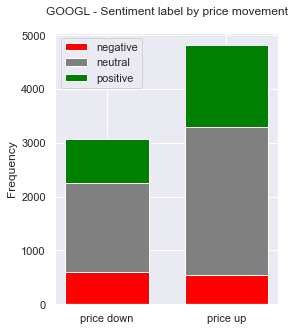

In [146]:
plot_sentiment(googl_sentiment_df, 'GOOGL')

In [144]:
stocks_merged[stocks_merged['stock'] == 'XOM']['sentiment_label'].value_counts(normalize=True)

neutral     0.583333
positive    0.234043
negative    0.182624
Name: sentiment_label, dtype: float64

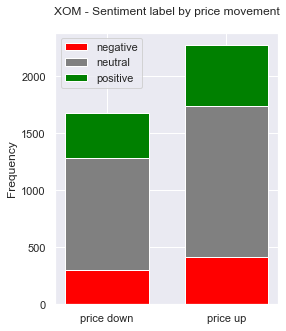

In [36]:
plot_sentiment(xom_sentiment_df, 'XOM')

In [147]:
stocks_merged[stocks_merged['stock'] == 'JPM']['sentiment_label'].value_counts(normalize=True)

neutral     0.613591
positive    0.230513
negative    0.155896
Name: sentiment_label, dtype: float64

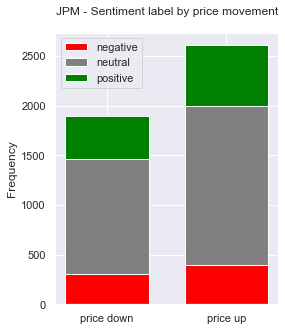

In [37]:
plot_sentiment(jpm_sentiment_df, 'JPM')

#### sentiment score

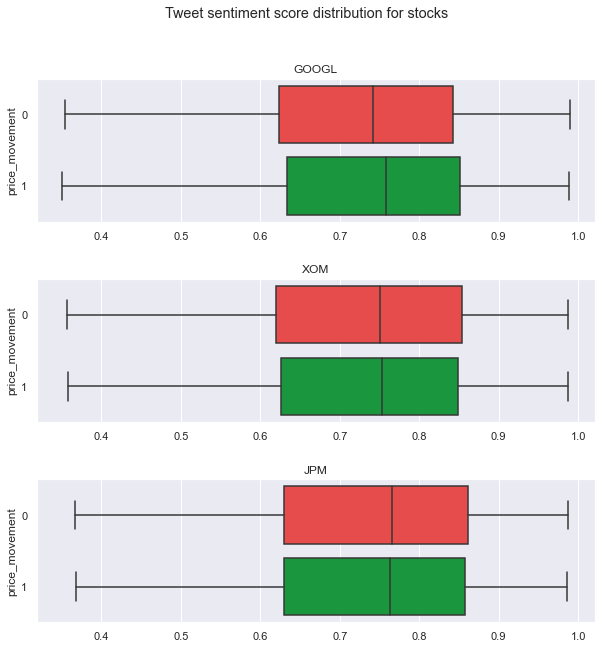

In [38]:
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle('Tweet sentiment score distribution for stocks')

for i, stock in enumerate(stocks):
    sns.boxplot(data=stocks_merged[stocks_merged.stock == stock], x='sentiment_score', y='price_movement', \
                orient='h', showfliers=False, palette=['#FF3333','#05AB37'], ax=ax[i])
    ax[i].title.set_text(stock)
    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel(None)

plt.subplots_adjust(hspace=0.4)  
plt.show();

### Correlation heatmap - numerical

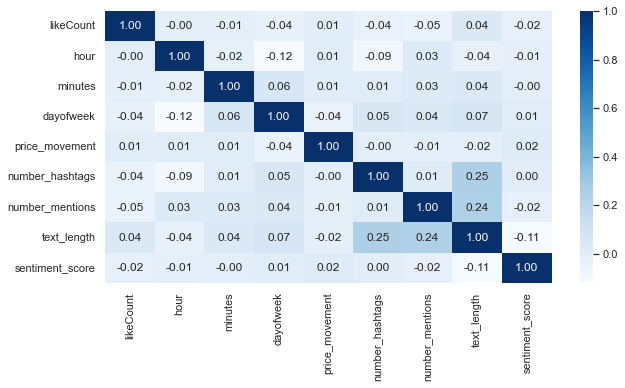

In [39]:
plt.figure(figsize=(10,5))
sns.heatmap(stocks_merged.corr(), cmap='Blues', annot=True, fmt='.2f');

### Correlation heatmp - categorical

Since we can't get correlation between categorical variables, we'll use this function for Cramers V

In [40]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [41]:
cat_cols.remove('date_x')

In [42]:
# Creating an extended category list and adding "price_movement" to see also correlation to target variable
cat_cols_corr = cat_cols
cat_cols_corr.append(('price_movement'))
print(cat_cols_corr)

['username', 'stock', 'sentiment_label', 'price_movement']


In [43]:
# Creating dataframe to capture correlation values from categorical features
corr_cat = pd.DataFrame(index=cat_cols_corr, columns=cat_cols_corr)

In [44]:
# Cycling thru categorical features to obtain correlation using Cramers V function
for cat in corr_cat.index:
    for col in corr_cat.columns:
        corr_cat.loc[cat, col] = cramers_v(stocks_merged[cat], stocks_merged[col])
        
# Converting values from string to float
corr_cat = corr_cat.astype(float)

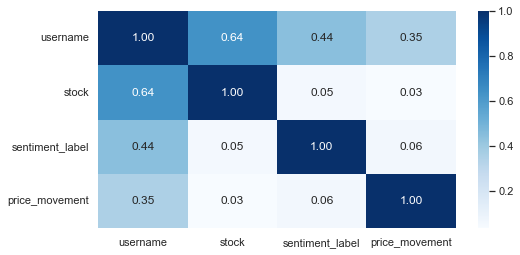

In [160]:
# plotting correlation heatmap for categorical variables
plt.figure(figsize = (8, 4))
sns.heatmap(corr_cat, cmap='Blues', annot=True, fmt='.2f');

## EDA for tweets text

Let's segment the tweets by stock so it's easier to reference them later.

In [46]:
googl_text = stocks_text[stocks_text['stock'] == 'GOOGL']
xom_text = stocks_text[stocks_text['stock'] == 'XOM']
jpm_text = stocks_text[stocks_text['stock'] == 'JPM']

Defining function to pull tweets with a specific word to analyze

In [47]:
def get_word_tweets(word, df):
    
    tweets_list = []
    price_list = []
    
    for tweet in df.iterrows():
        if word in tweet[1][1]:
            tweets_list.append(tweet[1][1])
            price_list.append(tweet[1][2])
    
    new_df = pd.DataFrame({'lem_text':tweets_list, 'price_movement':price_list})
    
    return new_df

Defining another function with the following purposes:
- Vectorize all our tweets using CountVectorizer based on a minimum document frequency that's passed as a function parameter
- It creates a basic Multinomial Naive Bayes model and calculates probability of each word in predicting an up movement
- Build a dataframe of good words (higher probability) and bad words (lower probability), you can adjust the number of words you want by passing as the number_words parameter
- Add to the dataframes the frequency of the word, as well as percentage that it was found in up or down movement.

In [48]:
def get_words(df, number_words, min_df=50):
    
    vectorizer = CountVectorizer(min_df=min_df, ngram_range=(1,1), stop_words='english')

    X = vectorizer.fit_transform(df['lem_text'])
    y = df['price_movement']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Training basic model
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train, y_train)

    words = np.array(vectorizer.get_feature_names_out())

    # Predicting probability for each word
    x = np.eye(X_test.shape[1])
    probs = nb_clf.predict_proba(x)[:, 0]
    ind = np.argsort(probs)

    # Subsetting only a specific number of words we want
    good_words = words[ind[:number_words]]
    bad_words = words[ind[-number_words:]]

    good_prob = probs[ind[:number_words]]
    bad_prob = probs[ind[-number_words:]]
    
    
    # Creating good words dataframe
    good_words_df = pd.DataFrame(columns=['word','probability'])

    for i in range(number_words):
        good_words_df.loc[i,'word'] = good_words[i]
        good_words_df.loc[i,'probability'] = round(1 - good_prob[i],2)
    
    for i, word in enumerate(good_words_df.iterrows()):
        tweets = get_word_tweets(word[1][0], df)
        good_words_df.loc[i,'word_frequency'] = tweets['price_movement'].count()
        good_words_df.loc[i,'perc_price_up'] = round(tweets[tweets['price_movement'] == 1]['price_movement'].count() / good_words_df.loc[i,'word_frequency'],2)
        good_words_df.loc[i,'perc_price_down'] = round(tweets[tweets['price_movement'] == 0]['price_movement'].count() / good_words_df.loc[i,'word_frequency'],2)

    good_words_df['word_frequency'] = good_words_df['word_frequency'].astype('int')
    
    
    # Creating bad words dataframe
    bad_words_df = pd.DataFrame(columns=['word','probability'])

    for i in range(number_words-1,-1,-1):
        bad_words_df.loc[i,'word'] = bad_words[i]
        bad_words_df.loc[i,'probability'] = round(1 - bad_prob[i],2)
    
    bad_words_df = bad_words_df.reset_index(drop=True)
    
    for i, word in enumerate(bad_words_df.iterrows()):
        tweets = get_word_tweets(word[1][0],df)
        bad_words_df.loc[i,'word_frequency'] = tweets['price_movement'].count()
        bad_words_df.loc[i,'perc_price_up'] = round(tweets[tweets['price_movement'] == 1]['price_movement'].count()/tweets['price_movement'].count(),2)
        bad_words_df.loc[i,'perc_price_down'] = round(tweets[tweets['price_movement'] == 0]['price_movement'].count()/tweets['price_movement'].count(),2)
    
    bad_words_df['word_frequency'] = bad_words_df['word_frequency'].astype('int')
    
    
    return good_words_df, bad_words_df

Now we'll use our functions to pull the good and bad words for predicting up movement for each stock. We'll have to play with the min_df parameter to see which one works best for each stock.

### GOOGL

In [49]:
googl_good_words, googl_bad_words = get_words(googl_text, 10, 40)

In [50]:
googl_good_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,_fire_,0.96,45,0.87,0.13
1,margin,0.9,65,0.78,0.22
2,elliottwave,0.89,77,0.86,0.14
3,pullback,0.88,48,0.73,0.27
4,weekend,0.86,43,0.74,0.26
5,_rocket_,0.85,58,0.88,0.12
6,march,0.84,51,0.80,0.20
7,box,0.83,62,0.77,0.23
8,content,0.83,44,0.77,0.23
9,rev,0.81,725,0.63,0.37


In [51]:
googl_bad_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,reuterstv,0.15,42,0.14,0.86
1,miss,0.2,145,0.30,0.70
2,live,0.29,88,0.45,0.55
3,wait,0.36,69,0.51,0.49
4,covid,0.36,46,0.39,0.61
5,user,0.37,64,0.45,0.55
6,inside,0.37,108,0.44,0.56
7,bull,0.39,209,0.66,0.34
8,drop,0.4,93,0.43,0.57
9,cnbc,0.42,71,0.49,0.51


Let's analyze some sample tweets for the top 3 good and bad words

In [52]:
# Increasing column width to be able to read tweets better
pd.set_option('display.max_colwidth',250)

# Disabling text formatting so it's easier to read (example: no bold, italic, etc)
pd.set_option('display.html.use_mathjax', False)

#### GOOGL - Good words

In [53]:
fire = get_word_tweets('_fire_',googl_text)
print(fire.price_movement.value_counts())
fire[fire.price_movement == 1].sample(5)

1    39
0     6
Name: price_movement, dtype: int64


,lem_text,price_movement
20,$googl this came in bullseye yesterday followed by in trady flow today a match in both tool is always a goo idea a it provides more confluence _folded_hands_ _fire_ httpstcopxppqotfmp,1
34,$googl absolutely crushed earnings _fire_ $b v estimate i have a position,1
26,$googl guess the quarter wa good enough youtube $b v $b consensus yoy search amp other $b v $b yoy _fire_ _fire_ _fire_ _fire_ $b fcf v $b consensus $ eps v $,1
37,@guyadami is right $googl is incredibly cheap here at these level after these number especially with a $b buyback _eyes_ going to take some time to digest overnight obviously but this is impressive year ago they preannounce this quarter or it’s u...,1
1,$googl #alphabet wed update vzolbo said buy the open today h c #moneyinthebank _smiling_face_with_sunglasses_ _fire_ _chart_increasing_,1


In [54]:
margin = get_word_tweets('margin',googl_text)
print(margin.price_movement.value_counts())
margin[margin.price_movement == 1].sample(5)

1    51
0    14
Name: price_movement, dtype: int64


,lem_text,price_movement
19,”why is that he then explained to me that there is no marginal benefit from switching to a competitor’s search product but the marginal cost can be high that’s when it suddenly dawned on me that google’s product are naturally monopolistic” $googl...,1
54,$googl alphabet q earnings revenue $b exp $b operating margin exp $ operating income $b exp $b eps $ exp $,1
26,google $googl cloud and youtube are incredibly strong run rate youtube $b run rate grew yy google cloud $b yy op margin overall and heading higher a cloud expense leverage core google op margin take core is strong growth strong httpstcokvivntrrmq,1
25,@tsohinvesting wonder if the inflection in $googl lends credence that we’ll see higher margin in servicescloudother bet once the profitability drag is gone the business becomes even more of a beast earnings compound faster and multiple expands me...,1
32,alphabet inc $googl q earnings eps $ est $ rev $b est $b other bet rev $m est $m oper income $b est $b oper income $b est $b oper margin est google cloud rev $b est $b,1


In [55]:
elliottwave = get_word_tweets('elliottwave',googl_text)
print(elliottwave.price_movement.value_counts())
elliottwave[elliottwave.price_movement == 1].sample(5)

1    66
0    11
Name: price_movement, dtype: int64


,lem_text,price_movement
8,$googl managed to reach blue box area last week from where reaction higher taking place any longs should be risk free by now #elliottwave #trading #google httpstcovradqqbzlr,1
43,$googl hr view from weekend update pullback entered into a blue box area from where buyer were expected to appear #elliottwave #trading #google httpstcozgjvqsiwc,1
17,$googl hr view from midday update the stock reached the blue box area and gave u a good a buying opportunity #elliottwave #trading #google find more at httpstcoqmivjbqer httpstcocjjcufb,1
50,$googl ha managed to reach the fib ret area from the peak at $ level therefore longs from blue box area should be risk free by now #elliottwave #trading #google httpstcokkxjwfmr,1
60,$googl hour update from october looking for #google to find buyer at blue box for wave rally at least #elliottwave #trading httpstcooguulhqsf,1


#### GOOGL - Bad words

In [56]:
reuterstv = get_word_tweets('reuterstv',googl_text)
print(reuterstv.price_movement.value_counts())
reuterstv[reuterstv.price_movement == 0].sample(5)

0    36
1     6
Name: price_movement, dtype: int64


,lem_text,price_movement
39,alphabet miss earnings estimate stock plummet httpstcoiiquuacq via @reuterstv $googl httpstcokwizputk,0
11,watch google will allow user to choose how long the company keep their data see more in this week tech playlist httpstcoutuqeaoej via @reuterstv $googl httpstcognbws,0
15,google is trying hard to convince consumer that it safe to trust them an issue it put front and center at it developer conference see more in this week tech playlist httpstcollbxohkzm via @reuterstv $googl httpstcolqyofieyzh,0
37,googleparent alphabet missed wall street estimate for firstquarter revenue posting it slowest growth in three year httpstcoiiquuacq via @reuterstv $googl httpstcofxvvjkwuz,0
35,watch google will allow user to choose how long the company keep their data more from the the io developer conference httpstcoutuqeaoej via the @reuterstv tech playlist $googl httpstcopbeedjnds,0


In [57]:
miss = get_word_tweets('miss',googl_text)
print(miss.price_movement.value_counts())
miss[miss.price_movement == 0].sample(5)

0    101
1     44
Name: price_movement, dtype: int64


,lem_text,price_movement
115,$googl wa in my today’s watchlist missed this trade clean move after trapping on both side #googl #twe #daytrading httpstcotlrhaemb,0
81,@alphatrends ya know what i do when i need to find a a dispensary $googl map imagine how annoying it would be if everything needed their own mapping service restaurant map gym map grocery store map i must be missing something,0
21,google $googl miss with eps of $ the stock is being whacked by around in the $s httpstcoidjicmgr,0
69,alphabet $googl saw eps of $adj v est rev wa $bn v the latter miss is giving the market an excuse to initially knock the stock httpstcoxnhihddjz,0
112,$googl slice the commission it take from subscription service on it app store httpstcosjrkunrht,0


In [58]:
live = get_word_tweets('live',googl_text)
print(live.price_movement.value_counts())
live[live.price_movement == 0].sample(5)

0    48
1    40
Name: price_movement, dtype: int64


,lem_text,price_movement
35,@realmoneys @chrisjversace ha hopped on our $googl live blog follow along here httpstcojkqzepwsy,0
71,google want to incorporate free adsupported streaming television channel into the live tab on google tv @jank say httpstcotiasngrxi in many way it trying to catch up to amazon and roku which already do this $googl,0
87,loving this breakout in $googl i called it out in one of our live charting webinars i’m long foe sep call and i’m up a lot already then k pt let’s goo httpstcorblzwxyjb,0
44,@katherinerooss is back to live tweet all thing alphabet $googl,0
12,how much help will #youtubetv be to live stream the super bowl httpstcoairdrmhohu #superbowl #live #broadcasts #tv #internet $googl #tech #checkthefineprint httpstcoairdrmhohu httpstcopqxcfilwh,0


### XOM

In [59]:
xom_good_words, xom_bad_words = get_words(xom_text, 10, 40)

In [60]:
xom_good_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,portfolio,0.78,48,0.73,0.27
1,member,0.77,72,0.74,0.26
2,debt,0.77,56,0.71,0.29
3,pay,0.76,137,0.64,0.36
4,say,0.74,135,0.73,0.27
5,bullish,0.74,110,0.74,0.26
6,end,0.73,817,0.57,0.43
7,work,0.72,83,0.63,0.37
8,dont,0.71,56,0.73,0.27
9,investor,0.71,133,0.66,0.34


In [61]:
xom_bad_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,break,0.34,131,0.58,0.42
1,really,0.35,47,0.38,0.62
2,view,0.35,87,0.49,0.51
3,sector,0.4,78,0.40,0.60
4,interesting,0.41,48,0.40,0.60
5,report,0.42,66,0.52,0.48
6,stockmarket,0.43,67,0.51,0.49
7,higher,0.44,91,0.43,0.57
8,elliottwave,0.44,66,0.48,0.52
9,engine,0.45,80,0.60,0.40


#### XOM - Good words

In [93]:
portfolio = get_word_tweets('portfolio', xom_text)
print(portfolio.price_movement.value_counts())
portfolio[portfolio.price_movement == 1].sample(5)

1    35
0    13
Name: price_movement, dtype: int64


,lem_text,price_movement
27,portfolio builder for conservative investor #investors#conservative#portfolio $xom exxon mobil share of this megacap energy leader backed up nicely a oil sold off in august and with people having hit the road for the holiday weekend there may hav...,1
6,updated analysis $xom exxon mobil dividend aristocrat intrinsic value analysis httpstcoexbhdlsej #dividends #energy #gas #oil #valueinvesting #dividend #investing #stocks #aaamportfolios httpstcowuktoebp,1
8,what stock in your portfolio are you most worried will _scissors_ cut their #dividend i’ll go first exxon mobil $xom @dividendgrowth @frugaltrader @thenelsonsmith @genymoneyca @cheesyfinance @myownadvisor @dividinvestor @thedividendguy @dividende...,1
24,@rinkydoofinance $xom is risky according to others… i don’t think so but it make up of the portfolio i haven’t bought any in a while but i’m sitting on a return considering i bought most near the bottom plus i get some pretty appetizing dividend ...,1
15,@wealthbabylon great analysis will definitely consider adding some $xom to my portfolio next week i’ve been slowly adding position of aristocrat recently so this is awesome to read _thumbs_up:_medium-light_skin_tone_,1


In [97]:
member = get_word_tweets('member', xom_text)
print(member.price_movement.value_counts())
member[member.price_movement == 1].sample(5)

1    53
0    19
Name: price_movement, dtype: int64


,lem_text,price_movement
30,@narutium @wholemarsblog they’re a small activist investor hedge fund that is attempting to force exxon to act responsibly on climate change impact by a ousting $xom board member amp replacing with environmentally friendly folk,1
19,moar #esg amp greenboondoggles republican sweep midterm in also long $xom on shortage amp long lines… growing up i remember oddeven license plate for gasoline are we going back there stay tuned… let’s see how hard they go on wind solar ev,1
14,remember a year ago when $xom wa being left for dead and oil wa never going to hit $ again gold today reminds me alot like that,1
44,@mktparticipants is it time to revisit $xom short again i remember we made solid profit on it a few month back it’s got the demark just wondering what your thought are at this stage,1
13,@ovlegacyvp @radkapital can i just tell you how impressive that is compared to a board like $xom that i looked over yesterday where none of the member have oil and gas or refining experience,1


In [99]:
debt = get_word_tweets('debt', xom_text)
print(debt.price_movement.value_counts())
debt[debt.price_movement == 1].sample(5)

1    40
0    16
Name: price_movement, dtype: int64


,lem_text,price_movement
10,@dodge @thedividendpig @dvdnddiplomats @thedividendguy for $xom at least year on fcf but debt is low so they may have some room asset disposal tough at this point httpstcoqbfvcovsuw,1
1,$xom and #shale are like a stubborn dog they just dont know when to quit growth is not something investor are interested in they want share buyback profit debt reduction and dividend guess they havent lost enough investor capital yet,1
50,reduce debt of crime against humanity cancel all new drilling to save billion new drilling is new extinction fuel major running carbon storage lethal conflict of interest #exxonmobil dividend growth debt reduction @themotleyfool #stocks $xom http...,1
16,the oil giant drowning in debt $xom httpstcoxyynjbxyu,1
13,isn’t $xom getting buried under debt,1


#### XOM - Bad words

In [101]:
break_ = get_word_tweets('break', xom_text)
print(break_.price_movement.value_counts())
break_[break_.price_movement == 0].sample(5)

1    76
0    55
Name: price_movement, dtype: int64


,lem_text,price_movement
84,$xom another daily chart breakout which i overnighted call on just not a lot of follow through with the market but a you can see once they break resistance and pattern they can rip httpstcolqcmitoltr,0
59,$xom breaking out at end of market close on high volume httpstcotquimpjehq,0
83,@pmack problem with adding here is it weighted on $xom which is currently breaking out i do think the inflation name take a big hit this month so your strike will be fine nonetheless,0
82,breaking activist investor engine win an extra rd seat on the board of exxon mobil last week’s preliminary result gave the activist two seat in a further blow to embattled ceo darren wood #oott $xom httpstcolztwdivzu,0
43,$xom with a massive breakdown yet on virtually no volume not even close to what we saw in the liquidation crisis really dont believe these thing will stay down here long may not explode higher but should get back near support in the next few mont...,0


In [66]:
really = get_word_tweets('really', xom_text)
print(really.price_movement.value_counts())
really[really.price_movement == 0].sample(5)

0    29
1    18
Name: price_movement, dtype: int64


,lem_text,price_movement
33,working on this handle might need another week or so really like the setup and in a strong sector watching close @aottrades $xom httpstcomhkjff,0
45,@atlasalphatrade @willrayvalentin we like $xom trade just watch if activist want div cut my view is they don’t want capex cut what the company really need is global refining back ethylene is doing great,0
42,$xom #riskreversal for feb th action confirmed but due to the cheap nature of the call this is really about the sold put im going to label this instead simply #deepitmcallbuying no risk reversal,0
15,$xom with a massive breakdown yet on virtually no volume not even close to what we saw in the liquidation crisis really dont believe these thing will stay down here long may not explode higher but should get back near support in the next few mont...,0
0,@phkhedge i think this is why a lot of the really good compounder record are in noncyclical industry you dont need to worry about timing the cyclical cash flow which is so so hard just look what ha happened to $xom over the last year,0


In [102]:
view = get_word_tweets('view', xom_text)
print(view.price_movement.value_counts())
view[view.price_movement == 0].sample(5)

0    44
1    43
Name: price_movement, dtype: int64


,lem_text,price_movement
21,$xom enters an uptrend a momentum indicator exceeded the level on may view odds for this and other indicator httpstcodnjzzgo #exxonmobil #stockmarket #stock #technicalanalysis #money #trading #investing #daytrading #news #today httpstcomukfggfo,0
49,$xom xom daily with fib ext and trendlines tradingview httpstcournzqzcfq,0
83,$xom in downtrend it price expected to drop a it break it higher bollinger band on january view odds for this and other indicator httpstcosjsktypi #exxonmobil #stockmarket #stock #technicalanalysis #money #trading #investing #daytrading #news #to...,0
29,$xoms aroon indicator reach into uptrend on march view odds for this and other indicator httpstcoppbakegv #exxonmobil #stockmarket #stock #technicalanalysis #money #trading #investing #daytrading #news #today httpstcogayychw,0
41,i highly recommend this succinct amp hilarious overview of exxonmobil thank you @kylascan for making such quality content $xom #energytwitter #energytransition #esg #climaterisk,0


### JPM

In [68]:
jpm_good_words, jpm_bad_words = get_words(jpm_text, 10, 50)

In [69]:
jpm_good_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,buyback,0.86,78,0.86,0.14
1,quarterly,0.79,55,0.82,0.18
2,dividend,0.73,132,0.73,0.27
3,financials,0.71,50,0.68,0.32
4,make,0.71,123,0.63,0.37
5,result,0.71,74,0.78,0.22
6,investing,0.71,79,0.62,0.38
7,silver,0.71,111,0.67,0.33
8,trade,0.71,250,0.64,0.36
9,company,0.7,58,0.69,0.31


In [70]:
jpm_bad_words

,word,probability,word_frequency,perc_price_up,perc_price_down
0,release,0.24,71,0.24,0.76
1,reserve,0.32,110,0.34,0.66
2,eps,0.38,202,0.43,0.57
3,income,0.4,112,0.52,0.48
4,friday,0.41,57,0.47,0.53
5,sell,0.41,82,0.61,0.39
6,work,0.41,109,0.55,0.45
7,loan,0.42,124,0.49,0.51
8,growth,0.43,77,0.55,0.45
9,expected,0.44,71,0.39,0.61


#### JPM - Good words

In [107]:
buyback = get_word_tweets('buyback', jpm_text)
print(buyback.price_movement.value_counts())
buyback[buyback.price_movement == 1].sample(5)

1    67
0    11
Name: price_movement, dtype: int64


,lem_text,price_movement
20,$jpm after b buyback news back to on monday httpstcowizsvqqaiq,1
70,jp morgan boost dividend to $ per share will continue buyback program bbg $jpm,1
43,$jpm jpmorgan chase set new $b buyback program after stress test httpstcopmojoryy,1
44,jamie diamond doe not mess around $jpm already out with a $ billion buyback announcement httpstcohksqpexf,1
64,jpmorgan to boost quarterly dividend to $shr to continue buyback $jpm,1


In [108]:
quarterly = get_word_tweets('quarterly', jpm_text)
print(quarterly.price_movement.value_counts())
quarterly[quarterly.price_movement == 1].sample(5)

1    45
0    10
Name: price_movement, dtype: int64


,lem_text,price_movement
8,breaking news on $jpm gt jpmorgan chase to report quarterly earnings learn more httpstcoxhudfu #dow #stocks #swingtrading #daytrading #jpmorgan #jpm,1
25,$jpm jpmorgan boost quarterly dividend to $share,1
23,$jpm jpmorgan chase increase quarterly dividend to $sh from $sh new yield,1
40,jpmorgan to boost quarterly dividend to $shr to continue buyback $jpm,1
44,$jpm jpmorgan chase intends to increase it quarterly dividend by to $ per share in q following fed stress httpstcojesaqwr,1


In [111]:
dividend = get_word_tweets('dividend', jpm_text)
print(dividend.price_movement.value_counts())
dividend[dividend.price_movement == 1].sample(5)

1    97
0    35
Name: price_movement, dtype: int64


,lem_text,price_movement
85,$jpm jpmorgan chase announces date for previously hiked dividend httpstcoxdpolsh,1
75,$jpm jpmorgan chase increase quarterly dividend to $sh from $sh new yield httpstcomebcyxpkz,1
83,$jpm jpmorgan chase increase quarterly dividend to $sh from $sh new yield httpstcomebcyxpkz,1
122,$jpm dividend day httpstcohceplrt,1
2,$jpm raise it dividend,1


#### JPM - Bad words

In [115]:
release = get_word_tweets('release', jpm_text)
print(release.price_movement.value_counts())
release[release.price_movement == 0].sample(5)

0    54
1    17
Name: price_movement, dtype: int64


,lem_text,price_movement
59,$jpm with a massive beat on the face of it but drive by a far bigger reserve release than expected $bn v $bn expected dimon we do not consider this core or recurring profit but the release bigger than expected only because outlook is too,0
68,$jpm report net income of $b and eps of $ for q or net income of $b and eps of $ excluding credit reserve release of $b stock flat pre market,0
40,$jpm report net income of $b and eps of $ for q or net income of $b and eps of $ excluding credit reserve release,0
52,$jpm jp morgan will release it earnings premarket tomorrow quick exercise that you could run on any stock looking at what is the implied move priced by option v historical move for more detail httpstcoufwvxlik httpstcodpgzgatcp,0
31,the eps beat wa materially from a $ billion reserve release ergo a low quality beat at $jpm @tomkeene @lisaabramowicz @ferrotv,0


In [119]:
reserve = get_word_tweets('reserve', jpm_text)
print(reserve.price_movement.value_counts())
reserve[reserve.price_movement == 0].sample(5)

0    73
1    37
Name: price_movement, dtype: int64


,lem_text,price_movement
69,$jpm jpmorgan q earnings part recovery of credit loss usdb est recovery usdm adj eps usd est usd quarterly number includes usdbln credit reserve release firmwide quarter includes credit cost net benefit of usdb,0
100,$jpm result beat but loan loss reserve change feel below buyside est down $bn gt $bn seems fairly weak given consumer strength and income gain etc all fiscal stimulus driven but #eft,0
81,@francescoppola @wintm @dimartinobooth @macroalf @andreassteno @bondstrategist @nakro @adamtooze @bhgreeley @jeffsnideraip @emilkalinowski @gamesblazer @epsilontheory @vmrconstancio @fwred @convertbond @marcmakingsense @hyunsongshin meanwhile at ...,0
95,#turkey creditdefault swap jump most on record in my opinion the story is just beginning turkey foreign exchange reserve are negative that mean it ha no way to protect the currency without swap a good time to remember that $jpm need to reduce it ...,0
78,reserve are cash for $jpm confirmed @animalspirits,0


In [124]:
eps = get_word_tweets('eps', jpm_text)
print(eps.price_movement.value_counts())
eps[eps.price_movement == 0].sample(5)

0    115
1     87
Name: price_movement, dtype: int64


,lem_text,price_movement
104,$jpm jpmorgan q earnings part cet ratio est released credit reserve of usdb eps usd est usd corporate investment bank ib fee usdb est usdb,0
22,#earnings _flag:_United_States_ _bank_ jpmorgan chase q net share repurchase $ billion $jpm eps $ v $ consensus _dollar_banknote_ @lauraguzmanv @davidgalanbolsa @laurablanco @lsruiz @luisvmunoz @vicentevaro @gneffa @arielsbdar @miguelboggiano @jm...,0
166,closing chart $jpm settled to $ jpm will effectively kick off q earnings season early wednesday epsrev should be fine with a positive outlook higher yield gt bullish u fin @petenajarian httpstcojubyzybuy,0
150,$jpm jpmorgan q earnings part recovery of credit loss usdb est recovery usdm adj eps usd est usd quarterly number includes usdbln credit reserve release firmwide quarter includes credit cost net benefit of usdb,0
98,the eps beat wa materially from a $ billion reserve release ergo a low quality beat at $jpm @tomkeene @lisaabramowicz @ferrotv,0


### Creating word clouds

#### GOOGL

In [77]:
cloud_googl_good_words, cloud_googl_bad_words = get_words(googl_text, 30, 40)

In [78]:
good_words_dict = {}
bad_words_dict = {}

for w, p in zip(cloud_googl_good_words['word'], cloud_googl_good_words['probability']):
    good_words_dict[w] = round(p,2)
    
for w, p in zip(cloud_googl_bad_words['word'], cloud_googl_bad_words['probability']):
    bad_words_dict[w] = round(1-p,2)

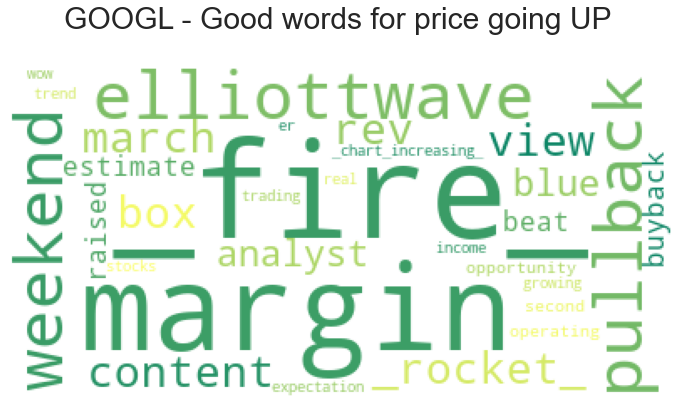

In [79]:
wordcloud_good = WordCloud(background_color='white', colormap='summer').generate_from_frequencies(good_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_good)
plt.axis("off")
plt.title('GOOGL - Good words for price going UP \n', fontdict={'fontsize':30});

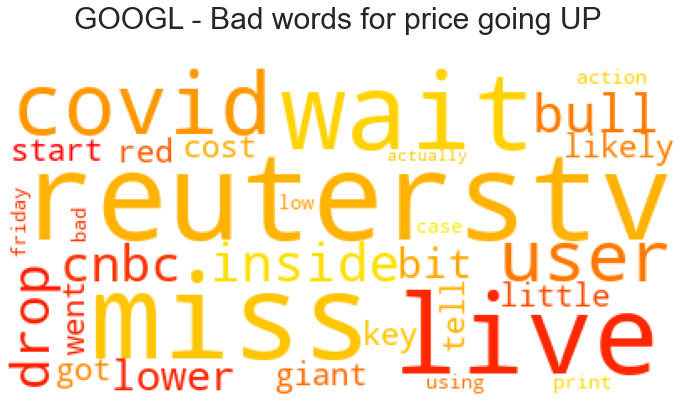

In [80]:
wordcloud_bad = WordCloud(background_color='white', colormap='autumn').generate_from_frequencies(bad_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_bad)
plt.axis("off")
plt.title('GOOGL - Bad words for price going UP \n', fontdict={'fontsize':30});

#### XOM

In [81]:
cloud_xom_good_words, cloud_xom_bad_words = get_words(xom_text, 30, 40)

In [82]:
good_words_dict = {}
bad_words_dict = {}

for w, p in zip(cloud_xom_good_words['word'], cloud_xom_good_words['probability']):
    good_words_dict[w] = round(p,2)
    
for w, p in zip(cloud_xom_bad_words['word'], cloud_xom_bad_words['probability']):
    bad_words_dict[w] = round(1-p,2)

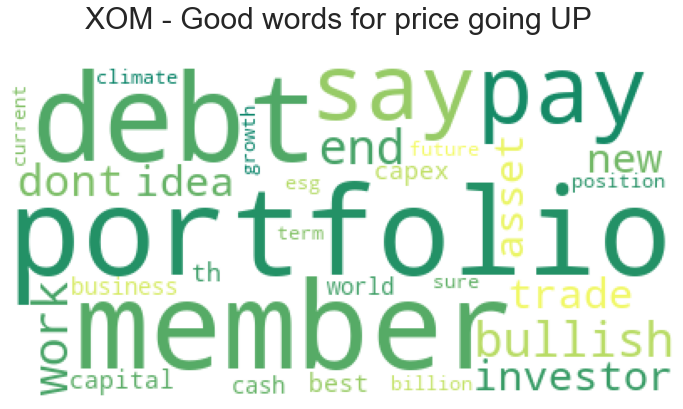

In [83]:
wordcloud_good = WordCloud(background_color='white', colormap='summer').generate_from_frequencies(good_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_good)
plt.axis("off")
plt.title('XOM - Good words for price going UP \n', fontdict={'fontsize':30});

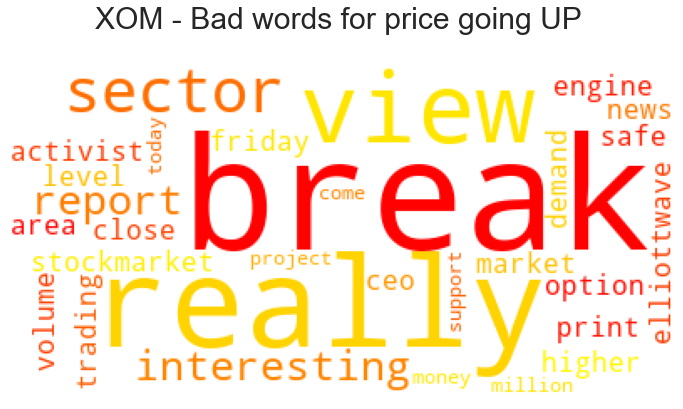

In [84]:
wordcloud_bad = WordCloud(background_color='white', colormap='autumn').generate_from_frequencies(bad_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_bad)
plt.axis("off")
plt.title('XOM - Bad words for price going UP \n', fontdict={'fontsize':30});

#### JPM

In [85]:
cloud_jpm_good_words, cloud_jpm_bad_words = get_words(jpm_text, 30, 50)

In [86]:
good_words_dict = {}
bad_words_dict = {}

for w, p in zip(cloud_jpm_good_words['word'], cloud_jpm_good_words['probability']):
    good_words_dict[w] = round(p,2)
    
for w, p in zip(cloud_jpm_bad_words['word'], cloud_jpm_bad_words['probability']):
    bad_words_dict[w] = round(1-p,2)

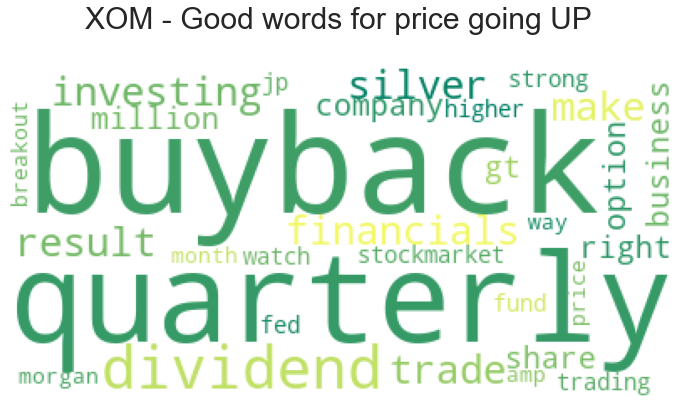

In [87]:
wordcloud_good = WordCloud(background_color='white', colormap='summer').generate_from_frequencies(good_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_good)
plt.axis("off")
plt.title('XOM - Good words for price going UP \n', fontdict={'fontsize':30});

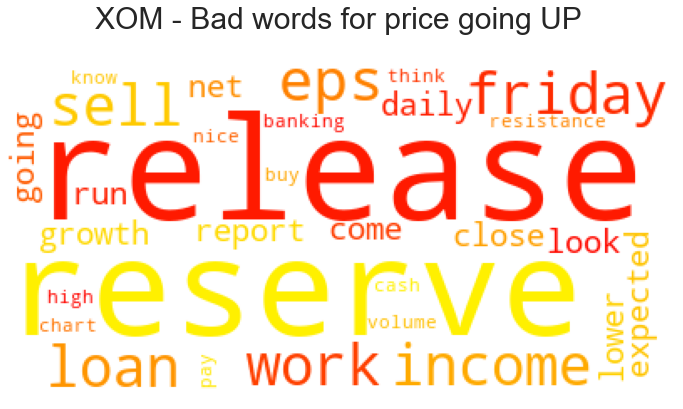

In [88]:
wordcloud_bad = WordCloud(background_color='white', colormap='autumn').generate_from_frequencies(bad_words_dict)
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_bad)
plt.axis("off")
plt.title('XOM - Bad words for price going UP \n', fontdict={'fontsize':30});